# 0. PVT论文回顾
### 摘要：
ViT很强，但几乎无法在下游任务中的应用。PVT融合了将广泛运用于下游任务中的金字塔结构安到了ViT上，提出了一个融合的网络，该网络在下游任务上表现强劲。

vit结合fastrcnn做目标检测，把resnet-50和FPN换掉了，效果很差
结构预览
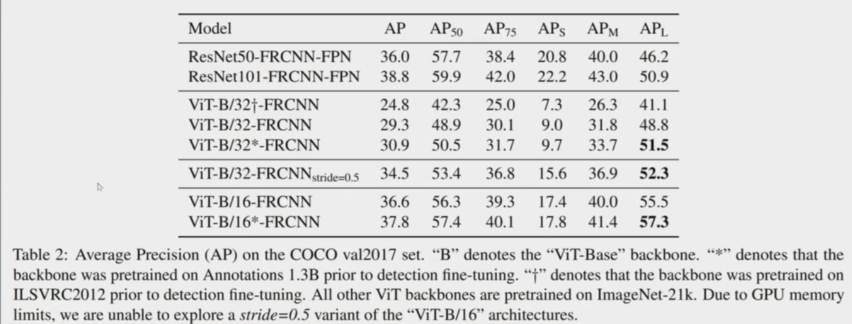
论文要点：
ViT的显存占用问题、PVT是如何解决的显存占用（SRA）、PVT的金字塔结构是如何实现的、以及timm风格的代码实现。
### Source code:
https://github.com/whai362/PVT/tree/v2/classification



PVT的研究意义:
展示了在下游任务中使用纯Transformer结构的一种方式引发了对“什么是一个好backbone"的思考

1，ViT在图像分类上表现强劲
2，但ViT的输出分辨率低，计算量大，显存开销大难以运用在下游任务上3，PVT利用了progressive shrinking pyramid，可以输出多种分辨率的Feature Map
4，PVT结合了CNNs和ViT的优势，实现了一个可以运用在多任务上的backbone
5，PVT在多种任务上都取得了不俗的结果


pvt构造了一个金字塔，每个block都是trans的block
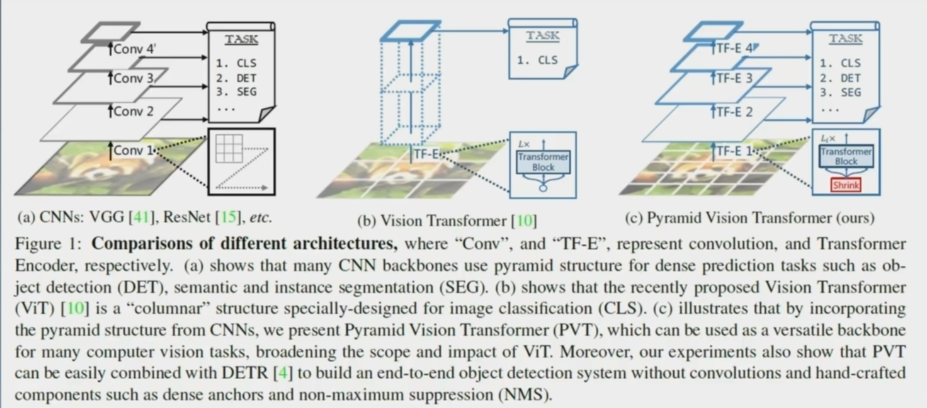

pvt的结构
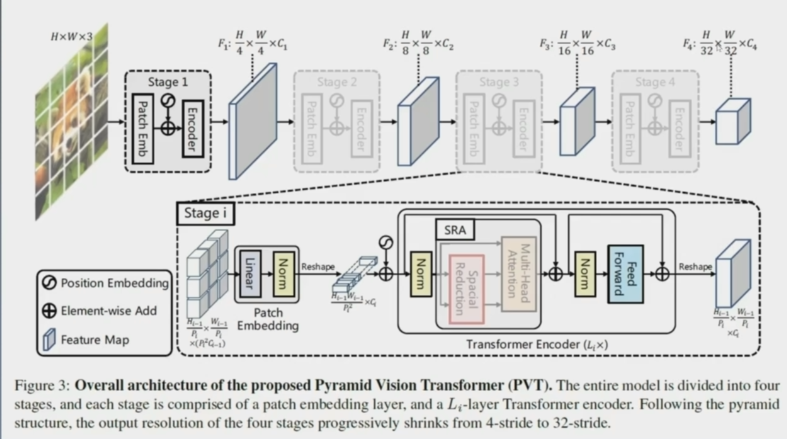

ViT中Feature Map的分辨率依赖于Patch Size但，最佳Patch size与输入的图片有关
但在绝大多数下游任务中高分辨率Feature Map是必备的
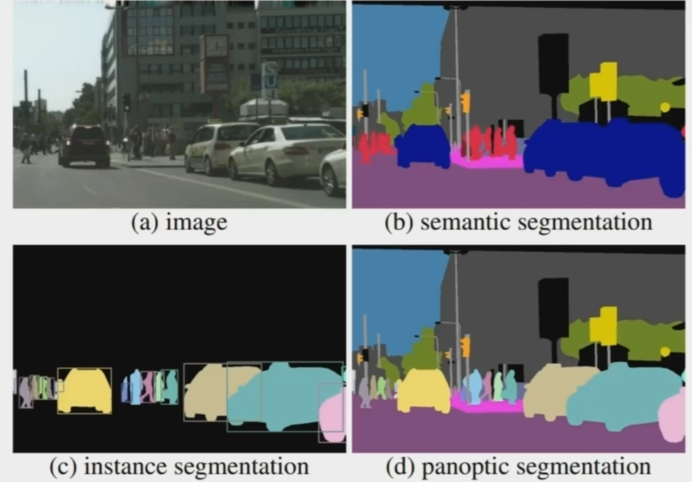


图像金字塔：获得尺度不变性
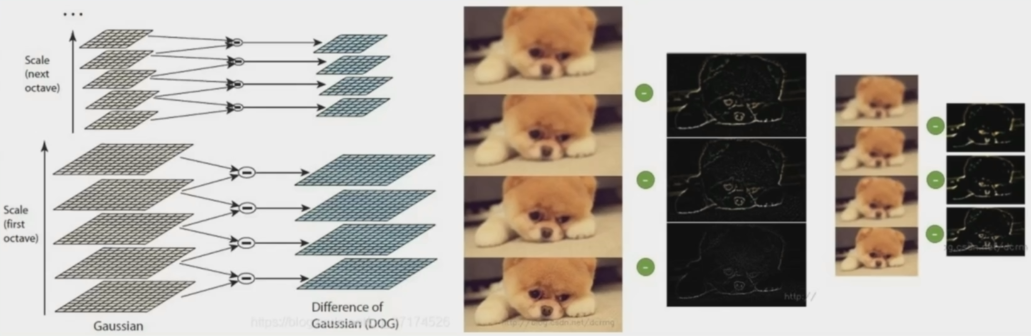

Spatial Pyramid Pooling
把Feature Map分成大小不同的块
然后对每个块内执行Max Pooling
拼起来就是图像的表示
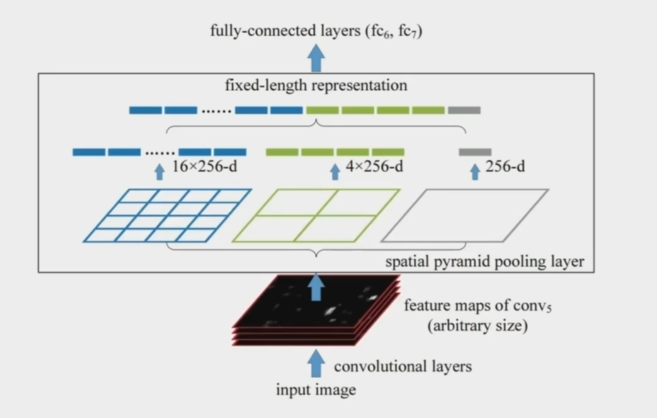


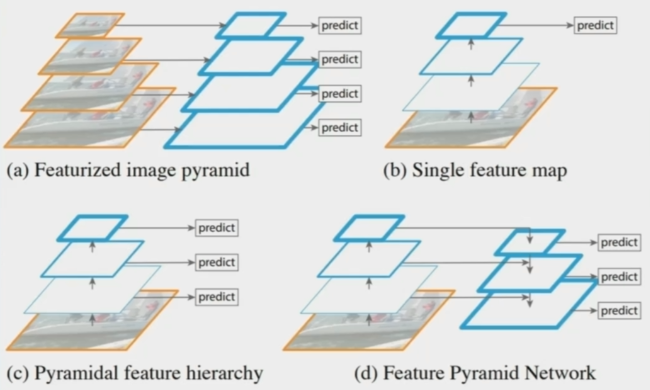

In [26]:
import torch
model = pvt_tiny()
img = torch.randn(1,3,224,224)
pred = model(img)

In [14]:
@register_model #装饰器，可以理解为自动调用的函数，功能是构造模型，load pretrain，为timm自带函数
def pvt_tiny(pretrained=False, **kwargs):
    model = PyramidVisionTransformer(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg() #指定一些config，比如resize中的插值方法等
    return model

### 1. 参数说明

pvt tiny的设置如下

img_size=224, patch_size=4, in_chans=3, num_classes=1000, embed_dims=[64, 128, 320, 512],
                 num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1], num_stages=4

- `image_size`: int.  
Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
- `patch_size`: int.
Patch size. 每个切分好的小片的大小。
- `in_chans`: int.
输入的通道数.
- `num_classes`: int.
类别数
- `embed_dims`: list.
每个patch用多少维来表示，不同stage用的不一样
- `num_heads`: list.
每个stage用多少个attention head，不同stage用的不一样
- `mlp_ratios`: list.
每个stage中的mlp_ratio是多少
- `depths`: list.
每个stage用几个block
- `sr_ratios`: list.
每个stage中sr_ratio是多少

### 2. PVT的前向过程总体讲解

### 3. 图像切分重排的Conv2d写法

能够这样写的原因是MLP和Conv2d的计算过程很像。

具体而言，MLP一般处理一维vector，方式为矩阵乘法，也就是n个点积，点积是先乘再加。Conv2d处理二维，方式为卷积，也就是随着窗口滑动的先乘再加。

MLP和Conv2d最重要的两点区别为局部连接、权重共享。

可以发现在图像切分重排这个过程中，所有的操作都在每个patch内(局部链接)，而且对于每个patch的操作是相同的(权重共享)，因此可以用conv替代。

In [29]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        # assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, \
        #     f"img_size {img_size} should be divided by patch_size {patch_size}."
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        H, W = H // self.patch_size[0], W // self.patch_size[1]
        return x, (H, W)

### 4. PVT中的Attention是怎么运行的(SRA的实现)
这里最主要的区别的是sr_ratio，如果没有这个，pvt就和vit一模一样。

通过实现可以发现，SRA中，每个Q与每个K的感受野不再一致。

### 5. PVT中的Pyramid是怎么实现的

### 6. 显存开销
这里直接参考下面这个link，具体模型是哪部分吃掉了显存说的很明白。

https://zhuanlan.zhihu.com/p/38142800

ViT的显存开销很高，这是因为在Attention计算过程中的一些中间变量和token(q,k,v)的数量指数相关。

主要是Attention Matrix的维度会涨的很快，比如input size=224，patch size=4，那么会有224/4 * 224/4 = 3136个token，Attention Matrix需要占用的显存数目为3136 * 3136 * head_num * 4B 约为 314m。若input size上升到800，那么所需显存为200 * 200 * 200 * 200 * head_num * 4B 约为 5w m。

但在SRA中，k的数量被限制了，所以这部分的显存开销也会减少一定的倍数，还是input size=224，patch size=4的情况下，q会有224/4 * 224/4 = 3136个，但k只有224/4/8 * 224/4/8 = 49 个，因此显存占用也会少到64分之一。

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg

__all__ = [
    'pvt_tiny', 'pvt_small', 'pvt_medium', 'pvt_large'
]


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        # B,N,T,Tc -> B,T,N,Tc
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            #B,QK,N,H,C -> ... -> QK,B,T,N,Tc
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        #然后把k，v拆分出来
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        print("attn.shape:", attn.shape)
        #print("v.shape:", v.shape)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        #print((attn@v).shape)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        # assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, \
        #     f"img_size {img_size} should be divided by patch_size {patch_size}."
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.proj(x).flatten(2).transpose(1, 2)
        '''
        x = self.proj(x)
        print("proj(x):", x.shape)
        x = x.flatten(2)
        print("flatten(x):", x.shape)
        x = x.transpose(1,2)
        print("transpose(x):", x.shape)
        '''
        x = self.norm(x)
        H, W = H // self.patch_size[0], W // self.patch_size[1]

        return x, (H, W)


class PyramidVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], num_stages=4):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0

        for i in range(num_stages):
            # patch_embed = 图像切分重排
            patch_embed = PatchEmbed(img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                                     patch_size=patch_size if i == 0 else 2,
                                     in_chans=in_chans if i == 0 else embed_dims[i - 1],
                                     embed_dim=embed_dims[i])
            num_patches = patch_embed.num_patches if i != num_stages - 1 else patch_embed.num_patches + 1
            #pos_embeding = positional embeding
            pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dims[i]))
            pos_drop = nn.Dropout(p=drop_rate)

            block = nn.ModuleList([Block(
                dim=embed_dims[i], num_heads=num_heads[i], mlp_ratio=mlp_ratios[i], qkv_bias=qkv_bias,
                qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + j],
                norm_layer=norm_layer, sr_ratio=sr_ratios[i])
                for j in range(depths[i])])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"pos_embed{i + 1}", pos_embed)
            setattr(self, f"pos_drop{i + 1}", pos_drop)
            setattr(self, f"block{i + 1}", block)

        self.norm = norm_layer(embed_dims[3])

        # cls_token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dims[3]))

        # classification head
        self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        # init weights
        for i in range(num_stages):
            pos_embed = getattr(self, f"pos_embed{i + 1}")
            trunc_normal_(pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        # return {'pos_embed', 'cls_token'} # has pos_embed may be better
        return {'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def _get_pos_embed(self, pos_embed, patch_embed, H, W):
        if H * W == self.patch_embed1.num_patches:
            return pos_embed
        else:
            return F.interpolate(
                pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
                size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def forward_features(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            #这里的getattr以及init中的setattr，都是为了把实现写进一个for循环中的
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            pos_embed = getattr(self, f"pos_embed{i + 1}")
            pos_drop = getattr(self, f"pos_drop{i + 1}")
            block = getattr(self, f"block{i + 1}")
            # patch_embed
            x, (H, W) = patch_embed(x)
            # cls_token在最后一个stage才加上，why？
            if i == self.num_stages - 1:
                cls_tokens = self.cls_token.expand(B, -1, -1)
                x = torch.cat((cls_tokens, x), dim=1)
                #这部分很奇怪的代码在实现预测时positional embedding插值。
                pos_embed_ = self._get_pos_embed(pos_embed[:, 1:], patch_embed, H, W)
                pos_embed = torch.cat((pos_embed[:, 0:1], pos_embed_), dim=1)
            else:
                pos_embed = self._get_pos_embed(pos_embed, patch_embed, H, W)

            x = pos_drop(x + pos_embed)
            #进Transformer block
            for blk in block:
                x = blk(x, H, W)
            if i != self.num_stages - 1:
                #从B,H,W,C 转到 B,C,H,W
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict

#定义大中小多种模型，以便后续使用。
@register_model
def pvt_tiny(pretrained=False, **kwargs):
    model = PyramidVisionTransformer(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_small(pretrained=False, **kwargs):
    model = PyramidVisionTransformer(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_medium(pretrained=False, **kwargs):
    model = PyramidVisionTransformer(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_large(pretrained=False, **kwargs):
    model = PyramidVisionTransformer(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_huge_v2(pretrained=False, **kwargs):
    model = PyramidVisionTransformer(
        patch_size=4, embed_dims=[128, 256, 512, 768], num_heads=[2, 4, 8, 12], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 10, 60, 3], sr_ratios=[8, 4, 2, 1],
        # drop_rate=0.0, drop_path_rate=0.02)
        **kwargs)
    model.default_cfg = _cfg()

    return model

In [59]:
import torch
model = pvt_tiny()
img = torch.randn(1,3,224,224)
pred = model(img)

attn.shape: torch.Size([1, 1, 3136, 49])
attn.shape: torch.Size([1, 1, 3136, 49])
attn.shape: torch.Size([1, 2, 784, 49])
attn.shape: torch.Size([1, 2, 784, 49])
attn.shape: torch.Size([1, 5, 196, 49])
attn.shape: torch.Size([1, 5, 196, 49])
attn.shape: torch.Size([1, 8, 50, 50])
attn.shape: torch.Size([1, 8, 50, 50])
